# PROJECT PENGOLAHAN CITRA DIGITAL

# Percobaan 1

### Mengimpor Library

In [724]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

Script di atas mengimpor berbagai library yang diperlukan untuk proses pengolahan citra, analisis data, dan implementasi machine learning. Library yang digunakan antara lain:
1. os - Digunakan untuk operasi sistem seperti manajemen file dan direktori  
2. cv2 (OpenCV) - Library utama untuk pemrosesan citra digital (membaca, memproses, dan menyimpan gambar)  
3. matplotlib.pyplot - Untuk visualisasi data dan gambar dalam bentuk plot dan grafik  
4. numpy - Library untuk komputasi numerik dan operasi array multidimensi  
5. pandas - Digunakan untuk manipulasi dan analisis data tabular  

Untuk kebutuhan machine learning, script menggunakan beberapa modul dari scikit-learn:  
- sklearn.model_selection (train_test_split, cross_val_predict) - Untuk pembagian dataset dan validasi silang  
- sklearn.feature_selection (SelectKBest, f_classif) - Untuk seleksi fitur optimal  
- sklearn.metrics - Berisi berbagai metrik evaluasi seperti accuracy_score, classification_report, confusion_matrix, dll  

Untuk ekstraksi fitur tekstur gambar digunakan:  
- skimage.feature (graycomatrix, graycoprops) - Untuk menghitung fitur tekstur GLCM (Gray Level Co-occurrence Matrix)  
- scipy.stats(entropy) - Untuk menghitung nilai entropi sebagai fitur tambahan  

Terdapat tiga algoritma klasifikasi yang diimplementasikan:  
1. RandomForestClassifier - Ensemble learning berbasis decision tree  
2. SVC (Support Vector Classifier) - Algoritma SVM untuk klasifikasi  
3. KNeighborsClassifier - Algoritma KNN berbasis jarak  

Untuk preprocessing dan visualisasi tambahan digunakan:  
- MinMaxScaler - Untuk normalisasi fitur  
- seaborn - Library visualisasi statistik yang memperindah tampilan plot  
- ConfusionMatrixDisplay - Untuk menampilkan confusion matrix secara visual 

### Buat Struktur Folder Dataset
```
.
└──dataset
    ├── label1
	├── image1.jpg
	├── image2.jpg
	└── image3.jpg
    ├── label2
    └── label3
    └── dst...
```

## Preparation

In [725]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset"):
    sub_folder_files = os.listdir(os.path.join("dataset", sub_folder))
    sub_folder_files = sub_folder_files[:70]  
    for filename in sub_folder_files:
        img_path = os.path.join("dataset", sub_folder, filename)
        img = cv.imread(img_path)
        
        data.append(img)
        labels.append(sub_folder)
        file_name.append(filename)

Kode di atas digunakan untuk mempersiapkan data gambar dari dataset. Pertama, tiga variabel disiapkan yaitu `data` untuk menyimpan gambar, `labels` untuk menyimpan kategori/kelas gambar, dan `file_name` untuk menyimpan nama file asli. 

Proses dimulai dengan membaca semua subfolder dalam direktori "dataset", dimana di setiap subfolder hanya diambil 70 gambar pertama dari setiap kategori menggunakan slicing `[:70]`. Setiap gambar kemudian dibaca menggunakan OpenCV (`cv.imread`) dari path yang dibentuk secara dinamis. 

Hasil pembacaan gambar disimpan dalam list `data`, sementara nama subfolder (sebagai label) dan nama file asli disimpan secara terpisah. 

## Prepocessing

### Fungsi Resize

In [726]:
def resize(img, target_height, target_width):
    height, width = img.shape
    resized_img = np.zeros((target_height, target_width), dtype=np.uint8)
    
    scale_x = width / target_width
    scale_y = height / target_height

    for i in range(target_height):
        for j in range(target_width):
            orig_x = min(int(j * scale_x), width - 1)
            orig_y = min(int(i * scale_y), height - 1)
            resized_img[i, j] = img[orig_y, orig_x]

    return resized_img

Fungsi `resize()` bekerja dengan mengubah ukuran gambar grayscale. Pertama, fungsi membuat canvas kosong dengan ukuran yang diinginkan. Kemudian menghitung seberapa besar gambar akan diperbesar atau diperkecil dengan membandingkan ukuran asli dan target. Untuk setiap titik pada gambar baru, fungsi mencari titik terdekat pada gambar asli dan menyalin nilai warnanya. Proses ini diulang untuk semua titik hingga gambar baru terisi penuh. Hasilnya adalah versi gambar yang sudah diubah ukurannya.

### Fungsi Normalize

In [727]:
def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized_img = (img - min_val) / (max_val - min_val) * 255
    return normalized_img.astype(np.uint8)

Fungsi `normalize()` ini akan melakukan normalisasi gambar untuk menyesuaikan rentang nilai pikselnya. Pertama dicari nilai piksel terendah (min_val) dan tertinggi (max_val) dalam gambar. Kemudian semua nilai piksel diubah skalanya agar tersebar merata antara 0 sampai 255.

rumus normalisasi: (nilai_piksel - min_val) / (max_val - min_val) * 255
hasilnya akan menggeser nilai minimum ke 0, merentangkan nilai-nilai lainnya secara proporsional, mengalikan dengan 255 agar mencakup seluruh rentang

### Fungsi Percobaan 2 (grayscale, resize, normalize)

In [728]:
def percobaan_1(img, target_height, target_width):
    gray_img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    resized_img = resize(gray_img, target_height, target_width)
    normalisasi = normalize(resized_img)
    return normalisasi

Fungsi ini adalah fungsi yang menerapkan percobaan menggunakan 3 preprocessing yaitu grayscale, resize, dan normalisasi
contoh: Gambar warna 400x600 → Grayscale 400x600 → Resize 100x100 → Normalisasi kontras → Output final

### Visualisasi Gambar untuk Klasifikasi

Kode dibawah akan melakukan serangkaian proses preprocessing dan visualisasi data gambar. Pertama, semua gambar diproses menggunakan fungsi percobaan_2 yang melakukan empat tahap yaotu konversi ke grayscale, penyesuaian ukuran menjadi 128x128 piksel, normalisasi intensitas pixel, dan smoothing untuk mengurangi noise. Hasil preprocessing ini disimpan dalam bentuk numpy array untuk memudahkan pengolahan selanjutnya.

Selanjutnya, kode melakukan visualisasi untuk memeriksa hasil preprocessing dengan menampilkan contoh gambar dari setiap kategori. Setiap kategori label (Dark, Green, Light, Medium) akan ditampilkan dalam bentuk grid 2x5 yang menampilkan 10 gambar contoh. Visualisasi ini menggunakan colormap grayscale dan memastikan konsistensi tampilan dengan mengatur range intensitas pixel antara 0-255. Jika suatu kategori tidak memiliki data, sistem akan memberikan peringatan.

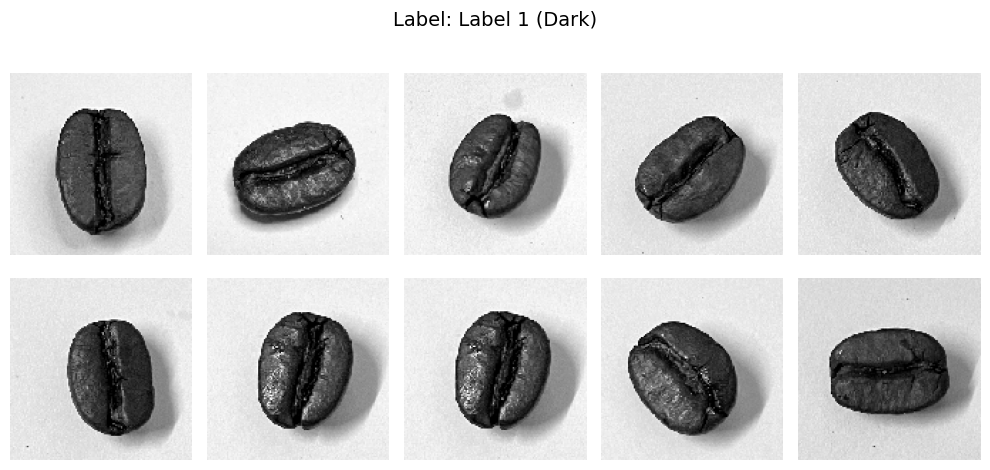

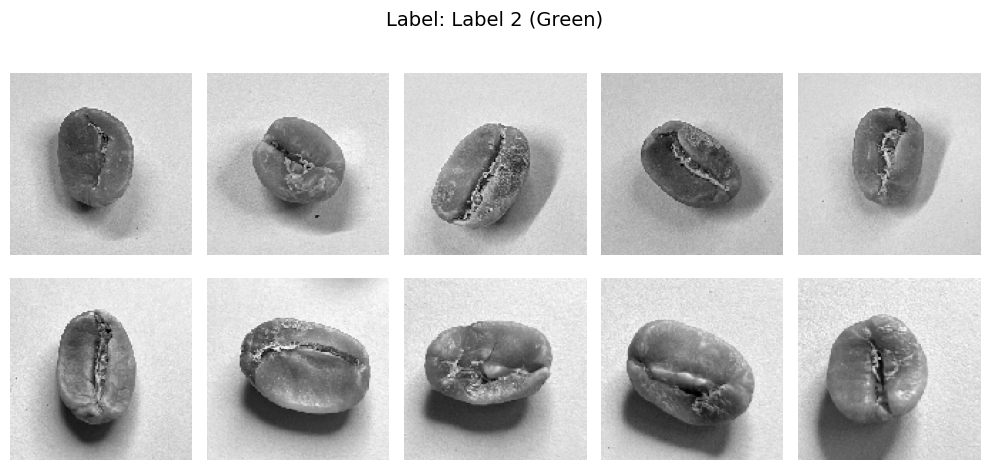

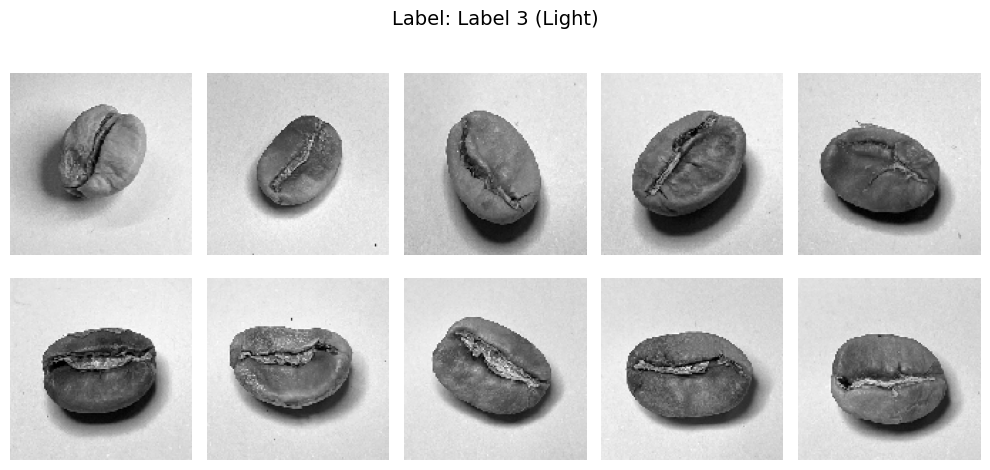

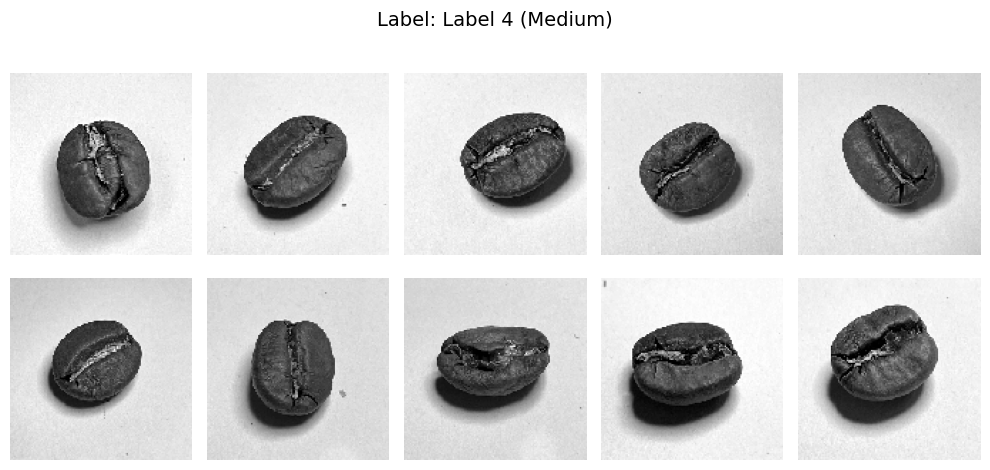

In [729]:
# pada bagian ini bisa gunakan data yang sebelum augmentasi atau setelah augmentasi
dataPreprocessed = [percobaan_1(img, 128, 128) for img in data]
dataPreprocessed = np.array(dataPreprocessed)
labels = np.array(labels)

label_names = {
    "Dark": "Label 1",
    "Green": "Label 2",
    "Light": "Label 3",
    "Medium": "Label 4"
}

for label_code in label_names:
    idxs = np.where(labels == label_code)[0][:10]

    if len(idxs) == 0:
        print(f"Tidak ada data untuk label '{label_code}'")
        continue

    plt.figure(figsize=(10, 5))
    plt.suptitle(f"Label: {label_names[label_code]} ({label_code})", fontsize=14)

    for i, idx in enumerate(idxs):
        plt.subplot(2, 5, i + 1)
        plt.imshow(dataPreprocessed[idx].squeeze(), cmap='gray', vmin=0, vmax=255)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

## Feature Extraction GLCM

In [730]:
def glcm(image, derajat):
    image = (image * 255).astype(np.uint8)  
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Fungsi ini menerima input citra grayscale dan sudut analisis tertentu (0°, 45°, 90°, atau 135°), kemudian melakukan konversi nilai pixel ke rentang 0-255 sebagai tahap awal. Proses utama menggunakan metode graycomatrix dari library skimage yang diatur dengan parameter spesifik seperti jarak antar pixel 1, normalisasi matriks, dan sifat simetris. Hasil GLCM yang dihasilkan merepresentasikan sebaran statistik pasangan nilai pixel pada relasi spasial tertentu, menjadi dasar untuk mengekstrak berbagai fitur tekstur seperti kontras, homogenitas, energi, dan korelasi. 

### Fungsi Correlation

In [731]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

Fungsi `correlation()` digunakan untuk mengukur tingkat keterkaitan linear antara pasangan piksel dalam suatu citra berdasarkan matriks GLCM. Fungsi ini bekerja dengan mengambil nilai korelasi tekstural dari matriks GLCM yang dihasilkan sebelumnya menggunakan metode graycoprops dari library skimage. Nilai korelasi yang dihasilkan berada dalam rentang -1 hingga 1, di mana nilai mendekati 1 menunjukkan hubungan linear yang kuat antara piksel-piksel bertetangga, nilai mendekati 0 menunjukkan tidak adanya hubungan linear, dan nilai negatif menunjukkan hubungan terbalik.

### Fungsi Dissimilarity

In [732]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

Fungsi `dissimilarity()` merupakan alat untuk mengukur ketidaksamaan tekstural dalam citra berdasarkan matriks GLCM. Fungsi ini bekerja dengan mengekstrak properti dissimilarity menggunakan graycoprops() dari library skimage, yang akan menghitung rata-rata selisih intensitas antara pasangan piksel bertetangga. Nilai dissimilarity yang dihasilkan merepresentasikan tingkat variasi lokal dalam tekstur citra, dimana nilai rendah menunjukkan tekstur yang seragam/halus, sementara nilai tinggi mengindikasikan tekstur kasar atau tidak teratur. Dalam implementasinya, [0, 0] digunakan untuk mengambil nilai dissimilarity pada jarak 1 piksel (indeks pertama) dan sudut pertama dalam GLCM (indeks kedua).

### Fungsi Homogenity

In [733]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

Fungsi  `homogenity()` digunakan untuk mengukur tingkat homogenitas tekstural dari citra berdasarkan matriks GLCM . Fungsi ini menghitung nilai homogenitas dengan memanfaatkan properti 'homogeneity' dari fungsi graycoprops() yang mengukur kedekatan distribusi elemen-elemen GLCM terhadap diagonal utama. Nilai homogenitas yang dihasilkan berada dalam rentang 0 hingga 1, nilai mendekati 1 menunjukkan tekstur yang sangat homogen (seragam) dengan perubahan intensitas pixel yang minimal, sementara nilai mendekati 0 mengindikasikan tekstur yang heterogen dengan variasi intensitas yang tinggi. Dalam implementasinya, [0, 0] digunakan untuk mengambil nilai homogenitas pada jarak 1 piksel dan sudut pertama yang dianalisis dalam GLCM. 

### Fungsi Contrast

In [734]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

Fungsi `contrast()` menghitung tingkat kontras tekstur dari matriks GLCM, mengembalikan nilai yang menunjukkan perbedaan intensitas piksel. Nilai rendah berarti tekstur halus, nilai tinggi berarti tekstur kasar. Menggunakan graycoprops() dengan parameter contrast dan mengambil nilai untuk jarak 1 piksel ([0,0]). Berguna untuk analisis tekstur dalam pengolahan citra

### Fungsi ASM

In [735]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

Fungsi `ASM()` menghitung energi tekstur (Angular Second Moment) dari GLCM, mengukur keseragaman distribusi pixel. Nilai tinggi (mendekati 1) menunjukkan tekstur homogen, sedangkan nilai rendah (mendekati 0) mengindikasikan variasi intensitas yang besar. Berguna untuk analisis pola tekstur dalam citra.

### Fungsi Energy

In [736]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

Fungsi `energy()` menghitung energi tekstur dari GLCM (nilai 0-1). Nilai tinggi = tekstur seragam, nilai rendah = tekstur acak. Menggunakan graycoprops() dengan parameter energy untuk jarak 1 piksel. Berguna untuk analisis keseragaman pola citra.

### Fungsi EntropyGLCM

In [737]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Fungsi `entropyGlcm()` menghitung entropi GLCM untuk mengukur kompleksitas tekstur. Nilai tinggi = tekstur acak/kompleks, nilai rendah = tekstur teratur/sederhana. Berguna untuk analisis pola citra.

In [738]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode ini menghitung matriks GLCM untuk 4 arah (0°, 45°, 90°, 135°) dari seluruh gambar yang sudah diproses. Hasilnya disimpan dalam 4 list terpisah (Derajat0, Derajat45, Derajat90, Derajat135) untuk analisis tekstur lebih lanjut. Berguna untuk menangkap karakteristik tekstur dari berbagai orientasi.

In [739]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Script di atas membuat list kosong untuk menyimpan nilai fitur tekstur yang dihitung dari matriks GLCM pada empat arah sudut sebelumnya. Setiap fitur tekstur mempunyai empat list terpisah yang khusus menampung hasil perhitungan pada masing-masing sudut. 

In [740]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

Script di atas melakukan perhitungan nilai correlation dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi correlation dipanggil dengan matriks GLCM pada sudut yang bersesuaian, kemudian hasilnya disimpan ke dalam list correlation0, correlation45, correlation90, dan correlation135. Script ini nantinya akan mengumpulkan nilai korelasi tekstur dari seluruh citra pada masing-masing arah.

In [741]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

Script di atas melakukan perhitungan nilai kontras dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi contrast dipanggil dengan matriks GLCM pada sudut yang bersesuaian, kemudian hasilnya disimpan ke dalam list Kontras0, Kontras45, Kontras90, dan Kontras135. Script ini nantinya akan mengumpulkan nilai kontras tekstur dari seluruh citra pada masing-masing arah.

In [742]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

Script di atas melakukan perhitungan nilai dissimilarity dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Pada setiap indeks citra, fungsi dissimilarity dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list dissimilarity0, dissimilarity45, dissimilarity90, dan dissimilarity135. Script ini bertujuan mengumpulkan nilai dissimilarity tekstur dari seluruh citra pada masing-masing arah.

In [743]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

Script di atas melakukan perhitungan nilai homogenitas dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi homogenity dipanggil dengan matriks GLCM pada sudut yang sesuai, lalu hasilnya disimpan ke dalam list homogenity0, homogenity45, homogenity90, dan homogenity135. Script ini mengumpulkan nilai homogenitas tekstur dari seluruh citra pada masing-masing arah sudut.

In [744]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

Script di atas melakukan perhitungan nilai entropi dari matriks GLCM untuk setiap citra yang ada pada img_smooth. Untuk setiap indeks citra, fungsi entropyGlcm dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list entropy0, entropy45, entropy90, dan entropy135. Script ini mengumpulkan nilai entropi tekstur dari seluruh citra pada masing-masing arah sudut.

In [745]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

Script di atas melakukan perhitungan nilai Angular Second Moment (ASM) dari matriks GLCM untuk setiap citra dalam img_smooth. Pada setiap iterasi, fungsi ASM dipanggil dengan matriks GLCM pada sudut yang sesuai, lalu hasilnya disimpan ke dalam list ASM0, ASM45, ASM90, dan ASM135. Script ini mengumpulkan nilai ASM yang merepresentasikan tingkat homogenitas tekstur dari seluruh citra pada masing-masing arah sudut.

In [746]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Script di atas melakukan perhitungan nilai energi dari matriks GLCM untuk setiap citra dalam img_smooth. Pada setiap iterasi, fungsi energy dipanggil dengan matriks GLCM pada sudut yang sesuai, kemudian hasilnya disimpan ke dalam list energy0, energy45, energy90, dan energy135. Script ini mengumpulkan nilai energi yang menggambarkan kekuatan atau intensitas tekstur dari seluruh citra pada masing-masing arah sudut.

In [747]:
# Gabungkan semua fitur dari setiap citra ke dalam satu array fitur per gambar
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        correlation0[i], correlation45[i], correlation90[i], correlation135[i],
        dissimilarity0[i], dissimilarity45[i], dissimilarity90[i], dissimilarity135[i],
        Kontras0[i], Kontras45[i], Kontras90[i], Kontras135[i],
        homogenity0[i], homogenity45[i], homogenity90[i], homogenity135[i],
        entropy0[i], entropy45[i], entropy90[i], entropy135[i],
        ASM0[i], ASM45[i], ASM90[i], ASM135[i],
        energy0[i], energy45[i], energy90[i], energy135[i],
    ]
    features.append(fitur)

# Ubah menjadi numpy array agar bisa digunakan di ML model
features = np.array(features)
labels = np.array(labels)


Fungsi ini menggabungkan 28 fitur tekstur GLCM (7 jenis fitur × 4 sudut) dari setiap citra ke dalam satu array terstruktur. Prosesnya mengiterasi seluruh data, mengumpulkan fitur-fitur seperti korelasi, dissimilarity, kontras, homogenitas, entropi, ASM, dan energy untuk setiap sudut (0°, 45°, 90°, 135°). Hasil akhir dikonversi ke numpy array (features dan labels) agar siap digunakan untuk pelatihan model machine learning.

# Hasil Ekstraksi ke CSV

In [748]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,dark (1).png,Dark,1178.586122,1335.195114,797.888472,1342.777358,0.167548,0.159080,0.178157,0.158840,...,0.001059,0.000976,0.031720,0.031145,0.032539,0.031244,0.899397,0.886451,0.931939,0.885806
1,dark (10).png,Dark,755.993418,1207.863166,1038.423659,1117.409821,0.197604,0.178834,0.188488,0.184772,...,0.003093,0.002973,0.055285,0.054125,0.055618,0.054528,0.944922,0.912424,0.924372,0.918982
2,dark (100).png,Dark,653.041585,868.108934,584.808255,725.379131,0.148269,0.137627,0.155640,0.142841,...,0.000918,0.000868,0.029859,0.029335,0.030292,0.029465,0.941013,0.921950,0.947209,0.934783
3,dark (101).png,Dark,835.802781,1060.291587,770.190945,858.901110,0.153283,0.138872,0.155420,0.144678,...,0.001190,0.001139,0.034127,0.033507,0.034501,0.033749,0.925546,0.905946,0.931420,0.923810
4,dark (102).png,Dark,976.279589,1056.321161,965.004737,1301.054870,0.138794,0.137582,0.146740,0.134217,...,0.001117,0.001048,0.032880,0.032524,0.033417,0.032372,0.916349,0.909918,0.917354,0.889048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,medium (158).png,Medium,762.465797,941.509951,705.297798,953.820820,0.200694,0.178823,0.207924,0.180990,...,0.000995,0.000876,0.031020,0.029736,0.031550,0.029598,0.948401,0.936543,0.952279,0.935713
276,medium (159).png,Medium,616.387303,814.950276,655.123893,848.102858,0.210713,0.195803,0.214118,0.194027,...,0.001320,0.001212,0.035806,0.034871,0.036335,0.034809,0.943761,0.926011,0.940215,0.923002
277,medium (16).png,Medium,747.144254,1010.556637,825.484375,885.462893,0.223381,0.197285,0.219209,0.205077,...,0.001312,0.001217,0.036237,0.034778,0.036216,0.034892,0.943432,0.923849,0.937510,0.933276
278,medium (160).png,Medium,653.187746,752.458057,560.296567,804.969744,0.194170,0.188204,0.200856,0.179464,...,0.002797,0.002689,0.052583,0.051964,0.052885,0.051859,0.945400,0.937375,0.953162,0.933004


## Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll
berikut contoh menggunakan ANOVA:

Kode ini melakukan seleksi fitur statistik dan analisis korelasi dalam tiga tahap utama. Pertama, data dipisahkan menjadi variabel fitur (X) dengan menghilangkan kolom Label dan Filename, serta variabel target (y) yang hanya berisi kolom Label. Tahap kedua menggunakan uji ANOVA F-test melalui SelectKBest untuk menyeleksi fitur-fitur paling signifikan secara statistik, dengan menerapkan threshold F-score sebesar 5 sebagai batas minimal signifikansi. Fitur-fitur yang lolos seleksi kemudian divisualisasikan dalam bentuk heatmap korelasi berukuran besar (17x17 inci) yang menampilkan nilai koefisien korelasi antar fitur dengan presisi dua desimal. 

<Axes: >

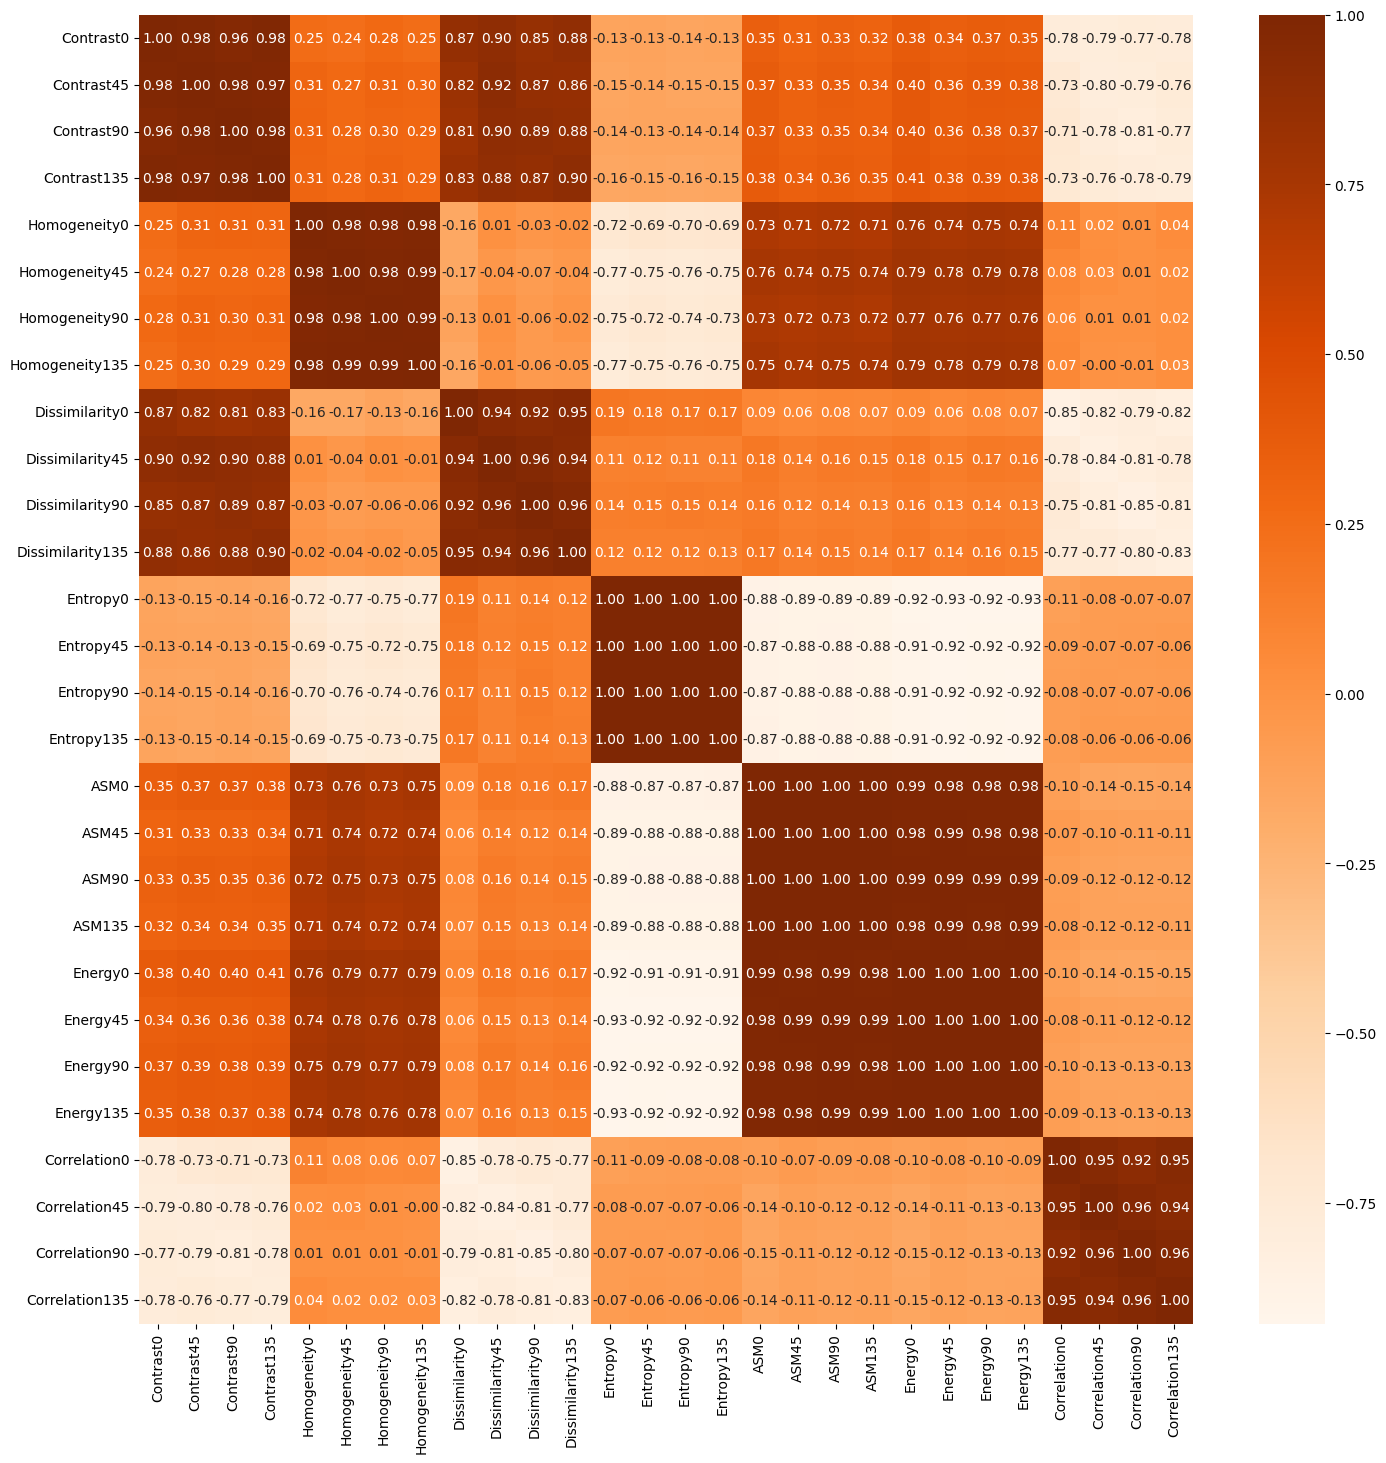

In [749]:
X = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']

# Hitung nilai ANOVA F-score untuk setiap fitur
anova_selector = SelectKBest(score_func=f_classif, k='all')  # 'all' agar kita dapat semua skor
anova_selector.fit(X, y)

# Ambil skor dan nama fitur
anova_scores = anova_selector.scores_
feature_names = X.columns

# Threshold manual (contoh: hanya ambil fitur dengan skor > 5)
threshold = 5
selected_features = feature_names[anova_scores > threshold]

# Tampilkan fitur yang lolos seleksi
x_new = X[selected_features]
x_new

plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Oranges', fmt=".2f")

## Splitting Data

In [750]:
# Memisahkan data menjadi data latih dan data uji
# test_size=0.2 artinya 20% data untuk pengujian, 80% untuk pelatihan
# random_state untuk memastikan hasil konsisten setiap kali dijalankan
# stratify=y memastikan distribusi label tetap seimbang antara train dan test
X_train, X_test, y_train, y_test = train_test_split(
    x_new, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)


print("Data Latih:", X_train.shape)
print("Data Uji:", X_test.shape)


Data Latih: (224, 28)
Data Uji: (56, 28)


Kode di atas berfungsi untuk membagi dataset x_new dan label y menjadi dua bagian, yaitu data latih dan data uji. Sebanyak 20% data akan digunakan untuk pengujian dan 80% sisanya untuk pelatihan. Parameter random_state digunakan agar pembagian data selalu konsisten setiap kali kode dijalankan, sementara stratify=y memastikan distribusi label pada data latih dan data uji tetap seimbang.

## Feature Normalization

berikut metode normalisasi yang bisa digunakan:

- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll
berikut contoh menggunakan mean std:

In [751]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode tersebut melakukan normalisasi pada data latih (X_train) dan data uji (X_test) menggunakan metode standar (mean-std normalization). Caranya adalah dengan mengurangkan nilai mean dari data latih dan membaginya dengan standar deviasi dari data latih. Proses ini bertujuan agar data memiliki distribusi normal dengan nilai rata-rata nol dan standar deviasi satu, sehingga membantu mempercepat dan meningkatkan performa algoritma machine learning.

In [752]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Kode ini melakukan normalisasi data menggunakan teknik Min-Max Scaling, MinMaxScaler diinisialisasi untuk mengubah nilai fitur ke range [0,1], Data training (X_train) di-fit dan di-transform sekaligus dengan fit_transform(), Data testing (X_test) hanya di-transform menggunakan parameter yang sudah dipelajari dari data training.

## Modeling

### Define Model

In [753]:
def generateClassificationReport(y_true, y_pred):
    print("Classification Report:")
    print(classification_report(y_true, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    
    print("Accuracy:", accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Fungsi generateClassificationReport dibuat untuk mengevaluasi performa model klasifikasi dengan menampilkan tiga metrik utama: (1) laporan klasifikasi lengkap (classification_report) yang mencakup presisi, recall, dan F1-score untuk setiap kelas, (2) matriks kebingungan (confusion_matrix) untuk melihat distribusi prediksi, dan (3) akurasi keseluruhan (accuracy_score). Kode ini juga menginisialisasi tiga model klasifikasi dengan parameter dasar: Random Forest dengan 5 pohon keputusan (RandomForestClassifier), SVM dengan kernel RBF (SVC), dan KNN dengan 5 tetangga terdekat (KNeighborsClassifier), dimana semua model menggunakan random_state=42 (kecuali KNN) untuk memastikan hasil yang reproducible.

## Train Random Forest Classifier

Model Random Forest dilatih menggunakan data training (X_train dan y_train) kemudian dievaluasi performanya baik pada data training maupun testing. Hasil prediksi pada data training (y_pred_train) menunjukkan kemampuan model mempelajari pola data, sementara prediksi pada data testing (y_pred_test) menguji kemampuan generalisasi model. Laporan klasifikasi yang dihasilkan menampilkan berbagai metrik evaluasi seperti akurasi, presisi, recall, dan F1-score untuk kedua set data.

In [754]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred_train = rf.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = rf.predict(X_test)
generateClassificationReport( y_test, y_pred_test)

------Training Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.98      1.00      0.99        56
       Green       0.98      0.98      0.98        56
       Light       0.98      0.98      0.98        56
      Medium       1.00      0.98      0.99        56

    accuracy                           0.99       224
   macro avg       0.99      0.99      0.99       224
weighted avg       0.99      0.99      0.99       224

Confusion Matrix:
[[56  0  0  0]
 [ 0 55  1  0]
 [ 0  1 55  0]
 [ 1  0  0 55]]
Accuracy: 0.9866071428571429

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.91      0.71      0.80        14
       Green       0.82      1.00      0.90        14
       Light       0.83      0.71      0.77        14
      Medium       0.75      0.86      0.80        14

    accuracy                           0.82        56
   macro avg       0.83      0.82  

## Train SVM Classifier

Kode ini melatih model SVM dengan X_train dan y_train, lalu mengevaluasinya pada data training dan testing. Fungsi generateClassificationReport menampilkan akurasi, presisi, recall, dan F1-score.

In [755]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = svm.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = svm.predict(X_test)
generateClassificationReport( y_test, y_pred_test)


------Training Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.83      0.89      0.86        56
       Green       0.98      0.84      0.90        56
       Light       0.83      0.96      0.89        56
      Medium       0.86      0.79      0.82        56

    accuracy                           0.87       224
   macro avg       0.88      0.87      0.87       224
weighted avg       0.88      0.87      0.87       224

Confusion Matrix:
[[50  0  0  6]
 [ 0 47  9  0]
 [ 0  1 54  1]
 [10  0  2 44]]
Accuracy: 0.8705357142857143

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.80      0.86      0.83        14
       Green       0.85      0.79      0.81        14
       Light       0.71      0.86      0.77        14
      Medium       0.82      0.64      0.72        14

    accuracy                           0.79        56
   macro avg       0.79      0.79 

## Train KNN Classifier

Kode ini melakukan pelatihan dan evaluasi model KNN (K-Nearest Neighbors) secara menyeluruh. Pertama, model dilatih menggunakan data training (X_train dan y_train) dengan metode fit(). Kemudian dilakukan evaluasi terhadap data training itu sendiri melalui predict() untuk melihat kemampuan memorisasi model, yang hasilnya ditampilkan dalam laporan klasifikasi mencakup metrik seperti akurasi, presisi, recall, dan F1-score. Selanjutnya model diuji dengan data testing (X_test) yang belum pernah dilihat sebelumnya untuk mengukur kemampuan generalisasinya.

In [756]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred_train = knn.predict(X_train)
generateClassificationReport( y_train, y_pred_train)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred_test = knn.predict(X_test)
generateClassificationReport( y_test, y_pred_test)



------Training Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.88      0.89      0.88        56
       Green       0.98      0.89      0.93        56
       Light       0.86      0.96      0.91        56
      Medium       0.89      0.84      0.86        56

    accuracy                           0.90       224
   macro avg       0.90      0.90      0.90       224
weighted avg       0.90      0.90      0.90       224

Confusion Matrix:
[[50  0  1  5]
 [ 0 50  6  0]
 [ 0  1 54  1]
 [ 7  0  2 47]]
Accuracy: 0.8973214285714286

------Testing Set------
Classification Report:
              precision    recall  f1-score   support

        Dark       0.79      0.79      0.79        14
       Green       0.86      0.86      0.86        14
       Light       0.80      0.86      0.83        14
      Medium       0.69      0.64      0.67        14

    accuracy                           0.79        56
   macro avg       0.78      0.79 

## Evaluation 

Fungsi `plot_confusion_matrix()` digunakan untuk memvisualisasikan matriks konfusi dengan input `y_true` (label asli) dan `y_pred` (prediksi model). Matriks ditampilkan dengan colormap biru (`plt.cm.Blues`) dan judul yang dapat disesuaikan. Contoh penerapannya ditunjukkan untuk tiga model: Random Forest (`rf.predict(X_test)`), SVM (`svm.predict(X_test)`), dan KNN, masing-masing dengan judul berbeda yang mencerminkan nama modelnya. Visualisasi ini membantu mengevaluasi performa klasifikasi dengan menampilkan jumlah prediksi benar (diagonal) dan kesalahan klasifikasi (off-diagonal).

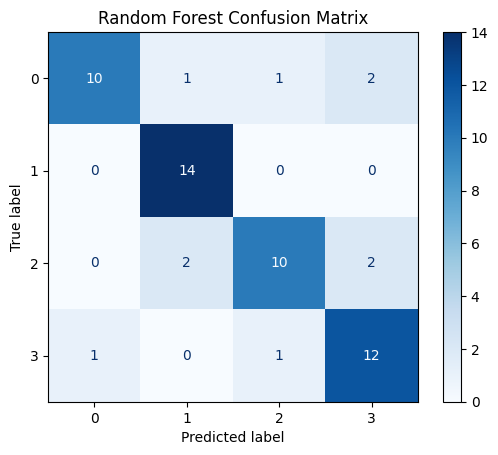

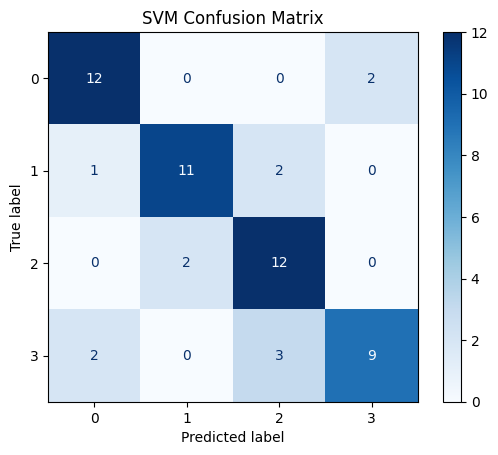

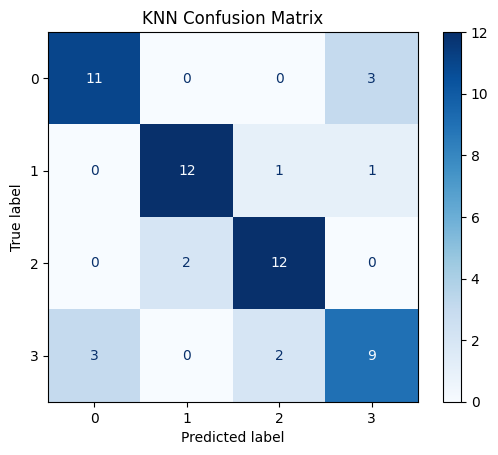

In [757]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")